In [1]:
pip install cmake

In [4]:
pip install dlib

In [5]:
pip install face_recognition

     |████████████████████████████████| 100.1 MB 9.7 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=617a27bb0f3add7d03fa66738ad0b75eda8c014ad535ad2a47c8f1b61b6bafe8
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [28]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo2.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo2.jpg


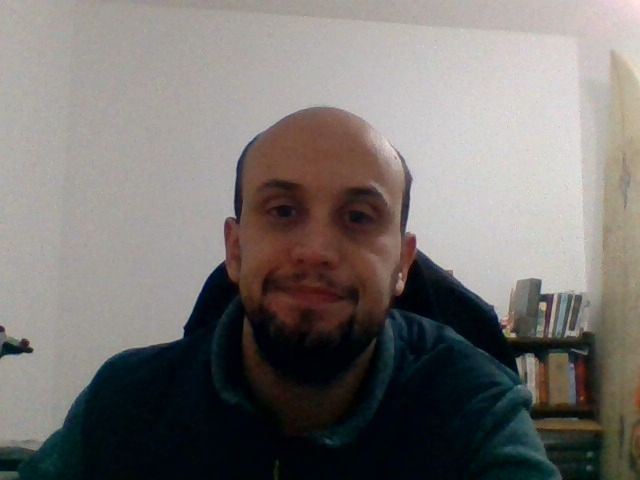

In [29]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [12]:
import face_recognition
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# This is a demo of running face recognition on live video from your webcam. It's a little more complicated than the
# other example, but it includes some basic performance tweaks to make things run a lot faster:
#   1. Process each video frame at 1/4 resolution (though still display it at full resolution)
#   2. Only detect faces in every other frame of video.

# PLEASE NOTE: This example requires OpenCV (the `cv2` library) to be installed only to read from your webcam.
# OpenCV is *not* required to use the face_recognition library. It's only required if you want to run this
# specific demo. If you have trouble installing it, try any of the other demos that don't require it instead.

# Get a reference to webcam #0 (the default one)
video_capture = cv2.VideoCapture('video.mp4')

# Load a sample picture and learn how to recognize it.
guille_image = face_recognition.load_image_file("Captura.JPG")
guille_face_encoding = face_recognition.face_encodings(guille_image)[0]

# Load a second sample picture and learn how to recognize it.
biden_image = face_recognition.load_image_file("biden.jpg")
biden_face_encoding = face_recognition.face_encodings(biden_image)[0]

# Create arrays of known face encodings and their names
known_face_encodings = [
    guille_face_encoding,
    biden_face_encoding
]
known_face_names = [
    "Guillermo!!",
    "Joe Biden"
]

# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

while True:
    # Grab a single frame of video
    ret, frame = video_capture.read()

    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    
    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]

    # Only process every other frame of video to save time
    if process_this_frame:
        # Find all the faces and face encodings in the current frame of video
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # # If a match was found in known_face_encodings, just use the first one.
            # if True in matches:
            #     first_match_index = matches.index(True)
            #     name = known_face_names[first_match_index]

            # Or instead, use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)

    process_this_frame = not process_this_frame


    # Display the results
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

        # Draw a label with a name below the face
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # Display the resulting image
    cv2_imshow(frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()

FileNotFoundError: ignored

In [43]:
import face_recognition

import math

def face_distance_to_conf(face_distance, face_match_threshold=0.6):
    if face_distance > face_match_threshold:
        range = (1.0 - face_match_threshold)
        linear_val = (1.0 - face_distance) / (range * 2.0)
        return linear_val
    else:
        range = face_match_threshold
        linear_val = 1.0 - (face_distance / (range * 2.0))
        return linear_val + ((1.0 - linear_val) * math.pow((linear_val - 0.5) * 2, 0.2))

video_capture = cv2.VideoCapture('video.mp4')
ret, frame = video_capture.read()

# Resize frame of video to 1/4 size for faster face recognition processing
small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    
# Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
rgb_small_frame = small_frame[:, :, ::-1]

# Often instead of just checking if two faces match or not (True or False), it's helpful to see how similar they are.
# You can do that by using the face_distance function.

# The model was trained in a way that faces with a distance of 0.6 or less should be a match. But if you want to
# be more strict, you can look for a smaller face distance. For example, using a 0.55 cutoff would reduce false
# positive matches at the risk of more false negatives.

# Note: This isn't exactly the same as a "percent match". The scale isn't linear. But you can assume that images with a
# smaller distance are more similar to each other than ones with a larger distance.

# Load some images to compare against
known_obama_image = face_recognition.load_image_file("photo2.jpg")
known_biden_image = face_recognition.load_image_file("biden.jpg")

# Get the face encodings for the known images
obama_face_encoding = face_recognition.face_encodings(rgb_small_frame)[0]
biden_face_encoding = face_recognition.face_encodings(known_biden_image)[0]

known_encodings = [
    obama_face_encoding
    
]

# Load a test image and get encondings for it
image_to_test = face_recognition.load_image_file("22.jpg")
image_to_test_encoding = face_recognition.face_encodings(image_to_test)[0]

# See how far apart the test image is from the known faces
face_distances = face_recognition.face_distance(known_encodings, image_to_test_encoding)

for i, face_distance in enumerate(face_distances):
    print("The test image has a distance of {:.2} from known image #{}".format(face_distance, i))
    print("- With a normal cutoff of 0.6, would the test image match the known image? {}".format(face_distance < 0.6))
    print("- With a very strict cutoff of 0.5, would the test image match the known image? {}".format(face_distance < 0.5))
    print(i,face_distance)
    print(face_distance_to_conf(face_distance))

The test image has a distance of 0.41 from known image #0
- With a normal cutoff of 0.6, would the test image match the known image? True
- With a very strict cutoff of 0.5, would the test image match the known image? True
0 0.40696925702154346
0.9311772251496581
